In [1]:
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.windows import from_bounds
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import numpy as np
from patchify import patchify

import torch
from torch.functional import F
from torch import nn
from torch.utils.data import DataLoader,TensorDataset
import fiona
from shapely.geometry import shape
import cv2
from pytorch_segmentation.inference import mosaic_to_raster
from pytorch_segmentation.data.inference_dataset import SatInferenceDataset
from pytorch_segmentation.utils.helper import split_raster_to_grid
#from pytorch_segmentation.utils.preprocessing import unpatchify,pad_image_topleft


seed = 42

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')


patch_size = [256,256] # [x,y,bands]
overlap = 128
padding = 64

bval = (255,255,255)
nworkers = 4
bs = 16

dataset_path = "data/datasets/inference_data.pkl"
data_path = "/home/jovyan/work/satellite_data/tmp/2018.vrt"
shape_path = "/home/jovyan/work/notebooks/satellite_data/data/2018_test_shapes_dense_forests.geojson"
#shape_path = "/home/jovyan/work/notebooks/satellite_data/utils/shapes/2015.shp"#"/home/jovyan/work/satellite_data/tmp/shapes/25/2018.shp"

model_name = "unet_08_12_2022_153943"#"unet_18_07_2022_150108_new"# #"unet_24_05_2022_141620"
model_path = "saved_models/" + model_name +  ".pth" #unet_15_03_2022_071331.pth" #unet_24_03_2022_064749.pth
out_path = "data/out/"+model_name

In [2]:
# data_path = "/home/jovyan/work/notebooks/satellite_data/data/rwanda/images/test/test_rwanda.vrt"

# shape_path = "/home/jovyan/work/notebooks/satellite_data/data/rwanda/Training_rectangles/rectangles_model_29.shp"

# 1. Data Loading and Preprocessing

In [3]:


dataset = SatInferenceDataset(data_file_path=data_path,shape_file=shape_path,overlap=128,padding=64,rescale_factor=1)
#dataset = SatInferenceDataset(data_file_path=data_path,shape_file=shape_path,overlap=64,padding=32,rescale_factor=2)
shapes = dataset.shapes.copy()
dataset.save(dataset_path)
 
#del dataset


100%|██████████| 6/6 [00:00<00:00, 1482.61it/s]


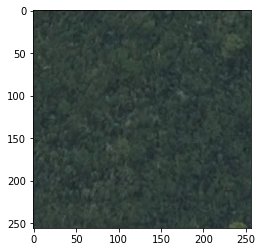

In [4]:
dataset.get_img(100)

# 2. UNet 


# 2.2 Unet

In [5]:
state_dict = torch.load(model_path)
# create new OrderedDict that does not contain `module.`
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v


In [6]:
from pytorch_segmentation.models import UNet
net = UNet(n_channels=3, n_classes=2, bilinear=False)
#net.load_state_dict(new_state_dict)
net.load_state_dict(torch.load(model_path,map_location="cpu"))
#net = net.to(device)
net.eval();



# Multi Process Queue In-Memory

In [7]:
from pytorch_segmentation.inference import mosaic_to_raster_mp_queue_memory
mosaic_to_raster(dataset_path,shapes,net,out_path,device_ids=[1],
                          bs=150,pin_memory=True,num_workers=15)

Total number of shapes:  6
Shape:  0
Queue PID:  16635


  0%|          | 0/20 [00:00<?, ?it/s]

Start GPU: 1


100%|██████████| 20/20 [00:05<00:00,  3.60it/s]


DONE  1
INFO: Written data/out/unet_08_12_2022_153943/2018_test_shapes_dense_forests_1.tif in 0.052 seconds
Shape:  1
Queue PID:  16635


  0%|          | 0/20 [00:00<?, ?it/s]

Start GPU: 1


100%|██████████| 20/20 [00:05<00:00,  3.61it/s]


INFO: Written data/out/unet_08_12_2022_153943/2018_test_shapes_dense_forests_2.tif in 0.047 seconds
Shape:  2
Queue PID:  16635


  0%|          | 0/20 [00:00<?, ?it/s]

Start GPU: 1


100%|██████████| 20/20 [00:05<00:00,  3.69it/s]


DONE  1
INFO: Written data/out/unet_08_12_2022_153943/2018_test_shapes_dense_forests_3.tif in 0.032 seconds
Shape:  3
Queue PID:  16635


  0%|          | 0/20 [00:00<?, ?it/s]

Start GPU: 1


100%|██████████| 20/20 [00:05<00:00,  3.70it/s]


DONE  1
INFO: Written data/out/unet_08_12_2022_153943/2018_test_shapes_dense_forests_4.tif in 0.213 seconds
Shape:  4
Queue PID:  16635


  0%|          | 0/20 [00:00<?, ?it/s]

Start GPU: 1


100%|██████████| 20/20 [00:06<00:00,  3.08it/s]


DONE  1
INFO: Written data/out/unet_08_12_2022_153943/2018_test_shapes_dense_forests_5.tif in 0.036 seconds
Shape:  5
Queue PID:  16635


  0%|          | 0/42 [00:00<?, ?it/s]

Start GPU: 1


100%|██████████| 42/42 [00:07<00:00,  5.73it/s]


DONE  1
INFO: Written data/out/unet_08_12_2022_153943/2018_test_shapes_dense_forests_6.tif in 0.050 seconds


['data/out/unet_08_12_2022_153943/2018_test_shapes_dense_forests_1.tif',
 'data/out/unet_08_12_2022_153943/2018_test_shapes_dense_forests_2.tif',
 'data/out/unet_08_12_2022_153943/2018_test_shapes_dense_forests_3.tif',
 'data/out/unet_08_12_2022_153943/2018_test_shapes_dense_forests_4.tif',
 'data/out/unet_08_12_2022_153943/2018_test_shapes_dense_forests_5.tif',
 'data/out/unet_08_12_2022_153943/2018_test_shapes_dense_forests_6.tif']